In [219]:
import os
import audtorch
import sounddevice as sd
import numpy as np
import torch
import torch.nn as nn

from audtorch.datasets import SpeechCommands
from audtorch import transforms

dataset_root = "/Users/harrisontaylor/Workspace/Datasets/" \
               "Audio/Speech/speech_commands_v0.02"

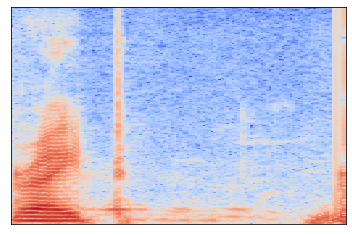

In [224]:
import librosa.display
import sounddevice as sd

class ToTensor(object):
    def __call__(self, sample):
        return torch.tensor(sample)
    
transform = [
    transforms.RandomCrop(4096*4, method='pad'),
    transforms.Normalize()]

wave_transform = transforms.Compose(transform)

spec_transform = transform.copy()
spec_transform[0] = transforms.RandomCrop(4096*4, method='replicate')
spec_transform.extend([
    transforms.Spectrogram(window_size=447, hop_size=130), # out size of [224, 96]. 447,172 if 4096*3. 447,130 if *4
    transforms.Log(),
    ToTensor()])
spec_transform = transforms.Compose(spec_transform)
    
dataset = SpeechCommands(
        root=dataset_root, train=True, 
        silence=False)

librosa.display.specshow(
    spec_transform(dataset[0][0]).numpy()[0,...])

# sd.play(wave_transform(dataset[0][0]),samplerate=16000)

In [236]:
commands = [
        'right', 'eight', 'cat', 'tree', 'backward',
        'learn', 'bed', 'happy', 'go', 'dog', 'no',
        'wow', 'follow', 'nine', 'left', 'stop', 'three',
        'sheila', 'one', 'bird', 'zero', 'seven', 'up',
        'visual', 'marvin', 'two', 'house', 'down', 'six',
        'yes', 'on', 'five', 'forward', 'off', 'four']

# n_classes = len(commands)

class VGGish(nn.Module):
    """
    Input:      224x96 amplitude log-spectrogram
    Output:     confidence for class in commands
    """
    def __init__(self, num_classes):
        super(VGGish, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,  64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512*14*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
net = VGGish(num_classes=len(commands))

x = spec_transform(dataset[0][0])[None,...]
out = net.forward(x)
print(torch.nn.functional.softmax(out))

tensor([[0.0283, 0.0284, 0.0287, 0.0286, 0.0293, 0.0285, 0.0283, 0.0285, 0.0287,
         0.0284, 0.0283, 0.0292, 0.0288, 0.0287, 0.0285, 0.0279, 0.0285, 0.0288,
         0.0278, 0.0283, 0.0285, 0.0289, 0.0288, 0.0287, 0.0282, 0.0291, 0.0283,
         0.0284, 0.0277, 0.0285, 0.0288, 0.0293, 0.0286, 0.0293, 0.0279]],
       grad_fn=<SoftmaxBackward>)


/Users/harrisontaylor/.conda/envs/vadr-demo/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
